# 期末综合练习（1）

### 设计一个CNN网络，训练自定义图像数据集的分类操作。 通过优化网络结构与超参数、正则化、数据增强等各种手段，尽可能提高准确率。（要求自建模型，形式不限，不能使用预定义模型）
Dataset Context：<BR>
This is image data of Natural Scenes around the world.<BR>
Dataset Content：<BR>
This Data contains around 25k images of size 96x96 distributed under 6 categories.<BR>
{'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2,
'mountain' -> 3,  'sea' -> 4, 'street' -> 5 }
<BR>
    
#### 要求：
1)利用callback将最佳模型保存到文件(注意：在"save"目录下建立以自己学号命名的子目录，然后在该子目录下保存文件)。显示loss曲线和accuracy曲线。<BR>
2)读取最佳模型进行指标评估并显示结果，展示混淆矩阵。<BR>
3)尝试展示典型图片的热力图<BR>

#### 考核办法：
1）程序功能完成度<BR>
2）score = model.evaluate(testset)<BR>
计算得到的准确率为指标，达到0.8为及格成绩起点，0.9优秀<BR>

In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,2048)

Sun Jun 25 00:30:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 58%   58C    P2   254W / 350W |  19053MiB / 24268MiB |     83%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
train_dataset_path='data/project/seg_train/seg_train'
validation_dataset_path='data/project/seg_test/seg_test'

In [4]:
IMG_WIDTH = 96
IMG_HEIGHT = 96
BATCH_SIZE = 32

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


In [6]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


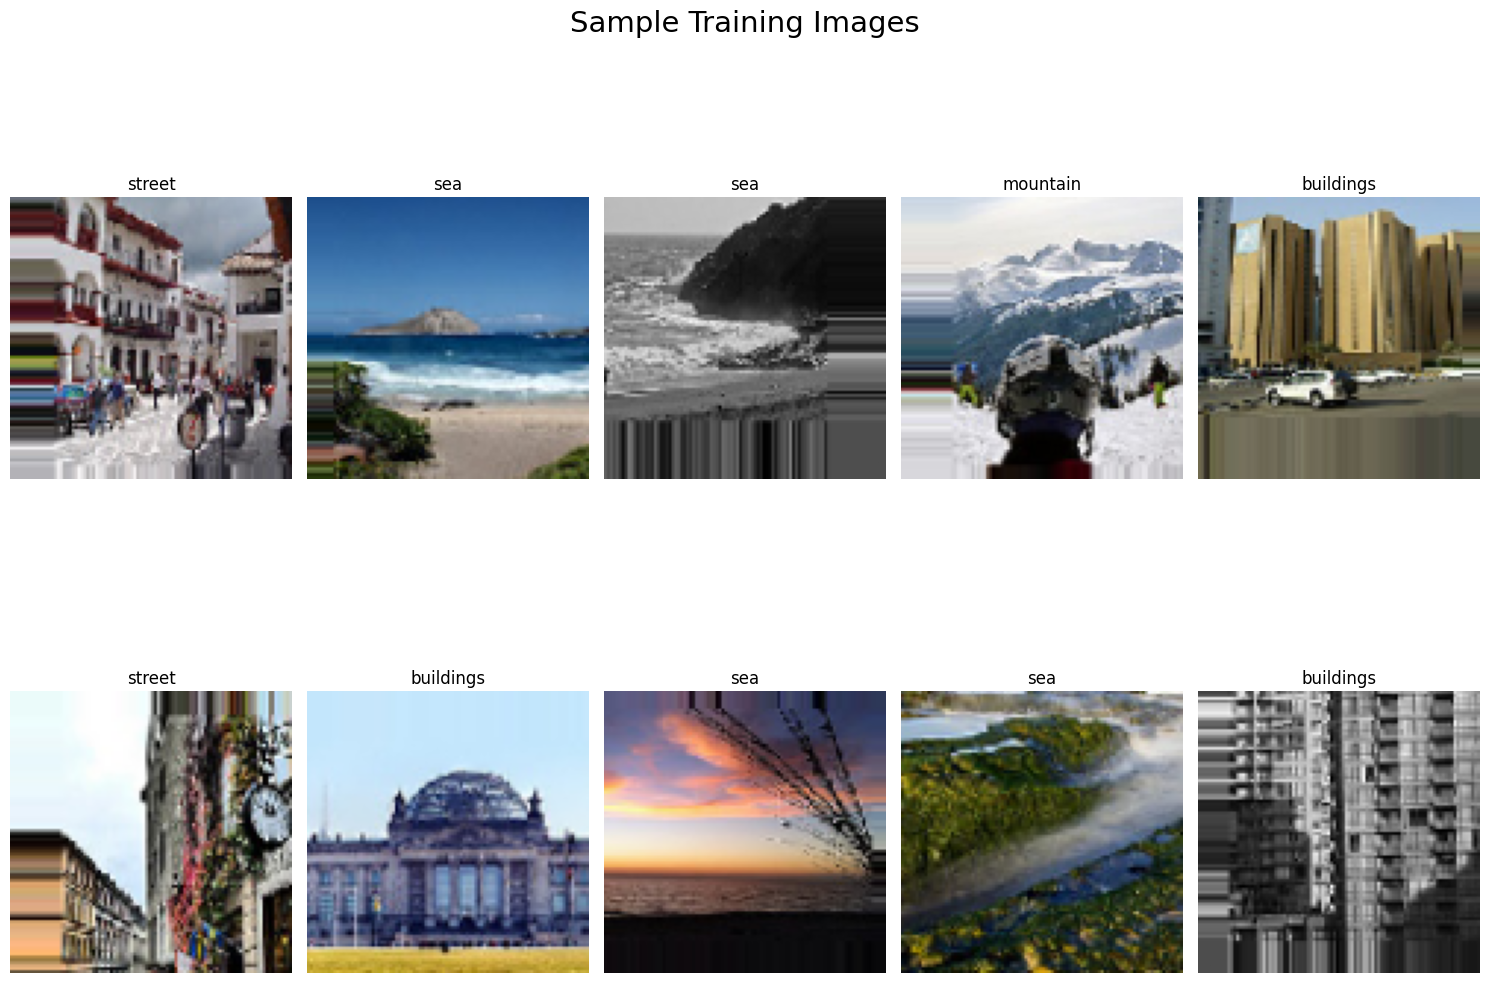

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [9]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [10]:
cnn_model = create_model()

In [11]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 128)       9728      
                                                                 
 activation (Activation)     (None, 92, 92, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [13]:
optimizer = Adam(learning_rate=0.001)

In [14]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [15]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
439/439 - 56s - loss: 1.5216 - accuracy: 0.5328 - val_loss: 1.1130 - val_accuracy: 0.5957 - lr: 0.0010 - 56s/epoch - 128ms/step
Epoch 2/50
439/439 - 48s - loss: 1.0235 - accuracy: 0.6280 - val_loss: 1.3910 - val_accuracy: 0.4680 - lr: 0.0010 - 48s/epoch - 109ms/step
Epoch 3/50
439/439 - 49s - loss: 0.8843 - accuracy: 0.6757 - val_loss: 0.6903 - val_accuracy: 0.7610 - lr: 0.0010 - 49s/epoch - 111ms/step
Epoch 4/50
439/439 - 47s - loss: 0.8039 - accuracy: 0.7068 - val_loss: 0.7596 - val_accuracy: 0.7173 - lr: 0.0010 - 47s/epoch - 107ms/step
Epoch 5/50
439/439 - 45s - loss: 0.7600 - accuracy: 0.7278 - val_loss: 0.9687 - val_accuracy: 0.6450 - lr: 0.0010 - 45s/epoch - 102ms/step
Epoch 6/50
439/439 - 48s - loss: 0.7073 - accuracy: 0.7453 - val_loss: 0.6208 - val_accuracy: 0.7977 - lr: 0.0010 - 48s/epoch - 110ms/step
Epoch 7/50
439/439 - 47s - loss: 0.6822 - accuracy: 0.7574 - val_loss: 0.7600 - val_accuracy: 0.7577 - lr: 0.0010 - 47s/epoch - 107ms/step
Epoch 8/50
439/439 - 48s - 

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

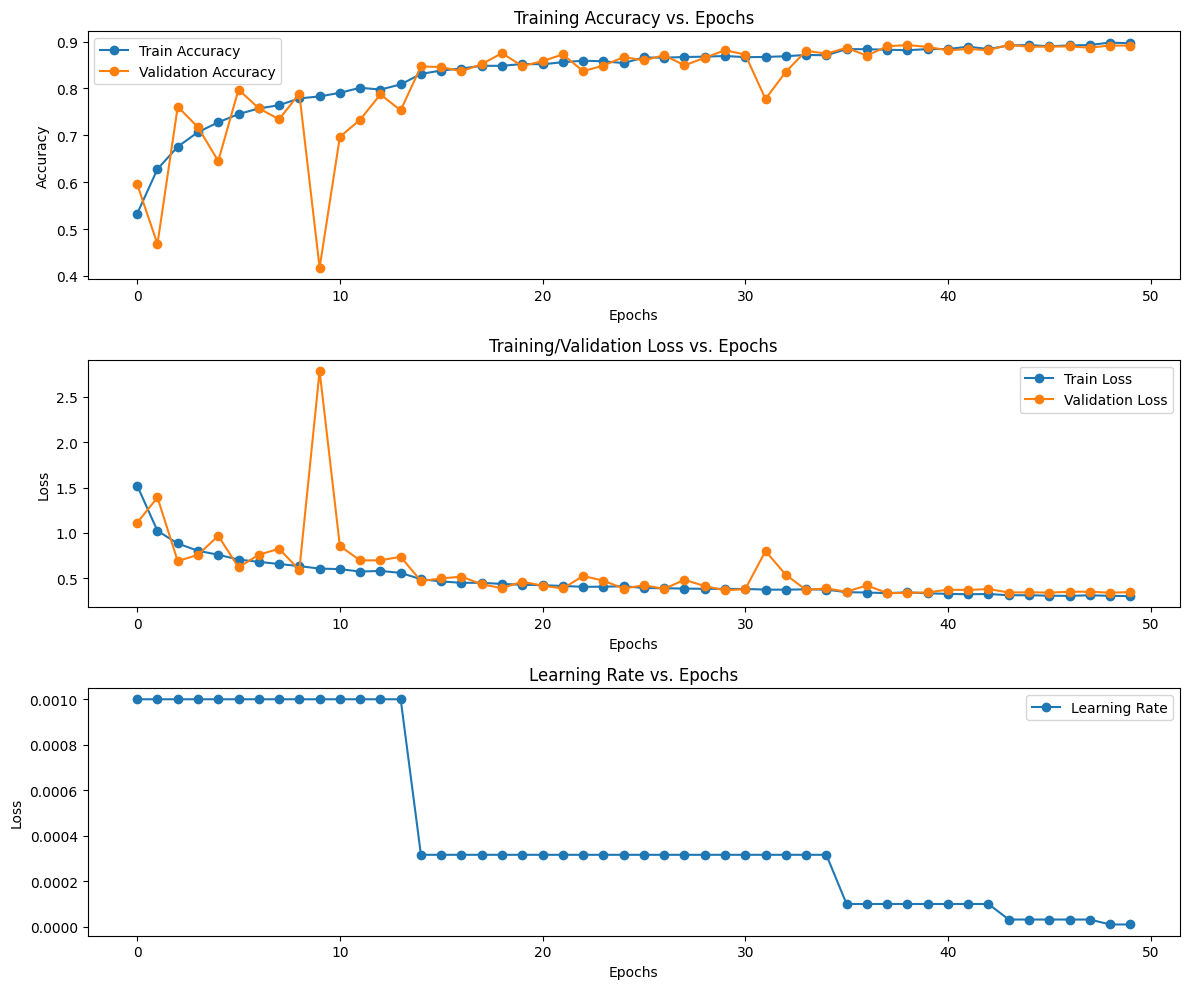

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [45]:
test_dataset = 'data/project/seg_test/seg_test'

In [46]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [47]:
predictions = cnn_model.predict(test_generator)

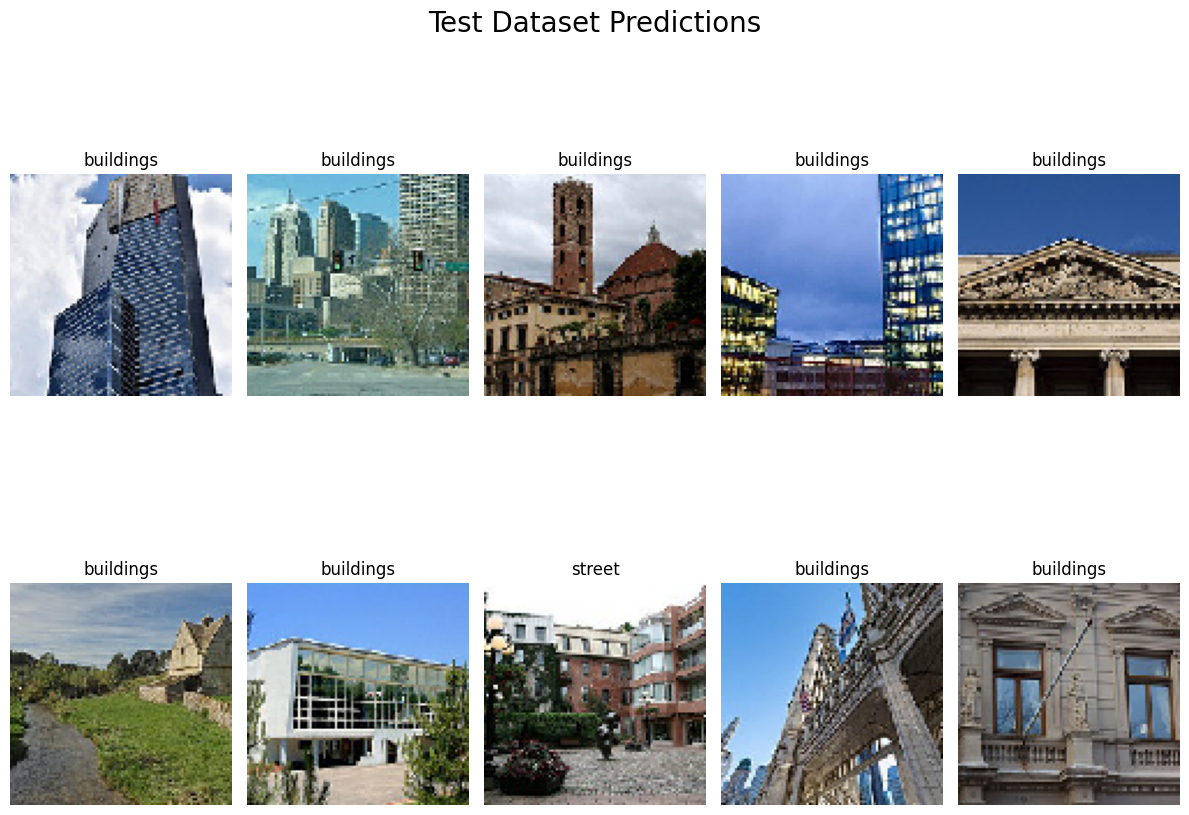

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [49]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

94/94 [==============================] - 4s 46ms/step - loss: 0.3487 - accuracy: 0.8913


In [50]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.3487250506877899
Test Accuracy: 0.8913333415985107


matrix

In [51]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

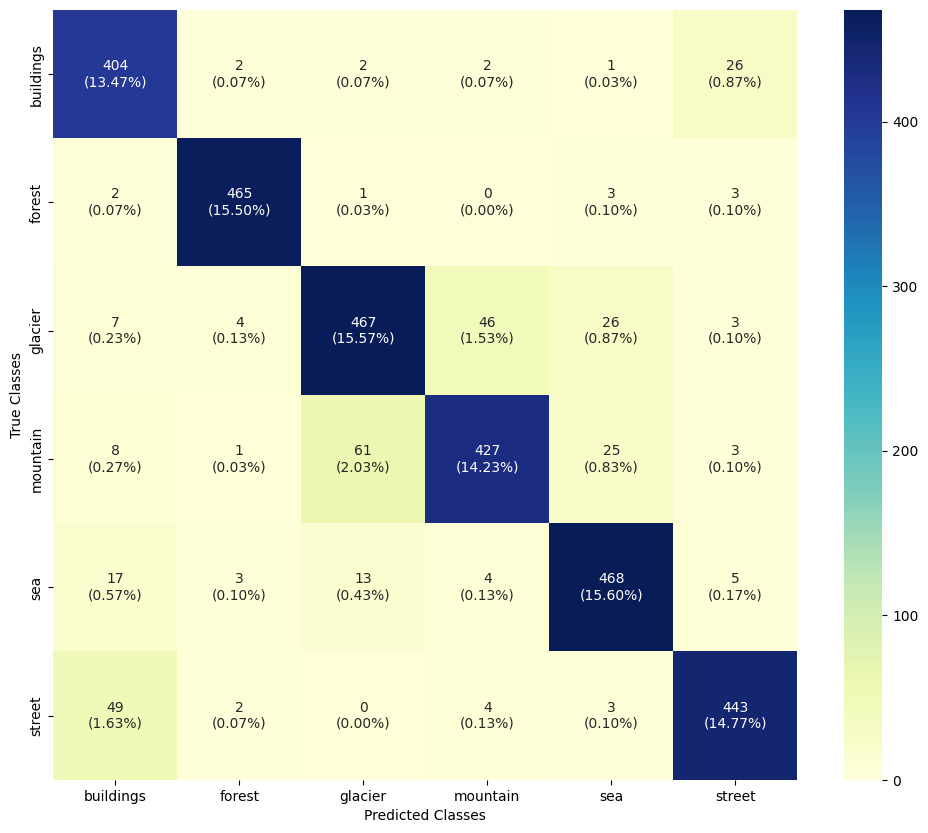

In [52]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [53]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.83      0.92      0.87       437
      forest       0.97      0.98      0.98       474
     glacier       0.86      0.84      0.85       553
    mountain       0.88      0.81      0.85       525
         sea       0.89      0.92      0.90       510
      street       0.92      0.88      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



In [54]:
cnn_model.save("save/3200105974/cnn_model.h5")

In [55]:
model1 = tf.keras.models.load_model('save/3200105974/cnn_model.h5')

In [ ]:
# 期末综合练习（2）

### 对keras内置路透社文本数据集进行内容分类（要求模型至少包含有两要素：CNN 、 RNN、 注意力机制）
即：Conv + RNN 或RNN + 注意力机制 或 CNN + 注意力机制
路透社数据集：<BR>
路透社数据集包含许多短新闻及其对应的主题，由路透社在1986年发布。包括46个不同的主题，其中某些主题的样本更多，但是训练集中的每个主题都有至少10个样本。<BR>
与IMDB数据集一样，路透社数据集也内置到了Keras库中，并且已经经过了预处理。<BR>
#### 提示：
由于文本较长，先用CNN卷积上采样到较短长度，再用RNN处理是一个避免梯度消失的方案。<BR>
    (由于卷积核为一维，卷积核大小要相应增大到5或7，stride增加到3或5)。<BR>
引入注意力机制是另一种克服遗忘的方案。<BR>
采用pytorch框架的同学，也利用keras读取数据集内容后进行训练
#### 要求：
利用callback将最佳模型保存到文件(注意：在"save"目录下建立以自己学号命名的子目录，然后在该子目录下保存文件)，
最后对最佳模型进行指标评估，展示混淆矩阵
#### 数据读取方法：
(x_train, y_train), (x_test, y_test) = keras.datasets.reuters.load_data(num_words=10000, test_split=0.2)

#### 考核办法：
1）程序功能完成度<BR>
2）计算得到的准确率为指标，准确率达到0.7为及格成绩起点，0.8以上优秀<BR>
score = model.evaluate(x_test, y_test)


#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,1024)

import numpy as np

from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# parameters for data load
num_words = 10000
maxlen = 50
test_split = 0.2

# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = num_words, maxlen = maxlen, test_split = test_split)
print(y_train.shape)
print(y_test.shape)

# pad the sequences with zeros 
# padding parameter is set to 'post' => 0's are appended to end of sequences
X_train = pad_sequences(X_train, padding = 'post')
X_test = pad_sequences(X_test, padding = 'post')

X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

y_data = np.concatenate((y_train, y_test))
y_data = to_categorical(y_data)
y_train = y_data[:1595]
y_test = y_data[1595:]
print(y_train.shape)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation,Input , Lambda,Dot,Attention
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# def deep_lstm():
#     model = Sequential()
#     model.add(LSTM(20, input_shape = (49,1), return_sequences = True))
#     model.add(LSTM(20, return_sequences = True))
#     model.add(LSTM(20, return_sequences = True))
#     model.add(LSTM(20, return_sequences = False))
#     model.add(Dense(46))
#     model.add(Activation('softmax'))
    
#     adam = optimizers.Adam(lr = 0.001)
#     model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
#     return model

from tensorflow.keras.models import Model




from tensorflow.keras import backend as K
def deep_lstm():
    inputs = Input(shape=(49, 1))
    lstm1 = LSTM(20, return_sequences=True)(inputs)
    lstm2 = LSTM(20, return_sequences=True)(lstm1)
    lstm3 = LSTM(20, return_sequences=True)(lstm2)
    
   # Apply attention to the output of the third LSTM layer
    attention = Attention()([lstm3, lstm3])
    
    lstm4 = LSTM(20, return_sequences=False)(attention)
    
    dense = Dense(46)(lstm4)
    outputs = Activation('softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)

    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

model=deep_lstm()
model.summary()

from tensorflow.keras.callbacks import ModelCheckpoint

filepath="save/3200105974/bestmodel.h5"

checkpoint=ModelCheckpoint(filepath,monitor='accuracy',verbose=0,save_best_only=True)
callbacks_list=[checkpoint]
# 模型训练
history = model.fit(X_train, y_train, epochs=10,
                    batch_size=50, verbose=1,callbacks=callbacks_list)

# history = model.fit(X_train, y_train, epochs = 200, batch_size = 50, verbose = 1)

score = model.evaluate(X_test, y_test)
score

from tensorflow.keras.models import load_model

newmodel=load_model(filepath)

score = newmodel.evaluate(X_test, y_test)
score



#### 总结说明
此处说明关于模型设计与模型训练（参数设置、训练和调优过程）的心得与总结

